In [1]:
import os, io
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import numpy as np
import time

from google.cloud import vision

In [2]:
def face_expression(face):
    values=np.array([face.anger_likelihood,
            face.joy_likelihood, face.sorrow_likelihood,
            face.surprise_likelihood, face.headwear_likelihood])
    key=("anger","joy","sorrow","surprise","headwear")
    likehood = ('Unknown', 'Very Unlikely', 'Unlikely', 'Possibly', 'Likely', 'Very Likely')
    max_index=np.argmax(values)
    return key[max_index]+ ": "+likehood[values[max_index]]

In [3]:
def drawVertices(image_source, response):
    pillow_img = Image.open(io.BytesIO(image_source))
    draw = ImageDraw.Draw(pillow_img)
    font = ImageFont.truetype('/Library/Fonts/Arial.ttf', 30) #Maybe different on non-Mac
    vertices_list=[i.bounding_poly.vertices for i in  response.face_annotations]
    text_list=[face_expression(i) for i in response.face_annotations ]
    
    for index, vertices in enumerate(vertices_list):
        for i in range(3): #4 points
            draw.line(((vertices[i].x, vertices[i].y), (vertices[i + 1].x, vertices[i + 1].y)),
                    fill='green',
                    width=8
            )
        draw.line(((vertices[len(vertices) - 1].x, vertices[len(vertices) - 1].y),
               (vertices[0].x, vertices[0].y)),
               fill='green',
               width=8
                 )
        
        draw.text((vertices[0].x + 10, vertices[0].y),
              font=font, text=text_list[index], 
              fill=(255, 255, 255))
    return pillow_img


In [4]:
def crop_image(image_source, response):
    pillow_img = Image.open(io.BytesIO(image_source))
    heads=[]
    vertices_list=[i.bounding_poly.vertices for i in  response.face_annotations]
    for vertices in vertices_list:
        left=min([i.x for i in vertices])
        top=min([i.y for i in vertices])
        right=max([i.x for i in vertices])
        bottom=max([i.y for i in vertices])
        new_img=pillow_img.crop((left, top, right, bottom))
        heads.append(new_img)
    return heads

In [5]:
def image_dis(content,response,zoom=100):
    new_img=drawVertices(content,response)
    width,height=int(new_img.width*zoom/100),int(new_img.height*zoom/100)
    return new_img.resize((width,height))

# 1 Get the response

In [6]:
#Get the key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../key.json'
client = vision.ImageAnnotatorClient()

In [7]:
#Just this
file_name = '3_nguoi.jpg'
# file_name = 'an.jpg'
image_path = f'{file_name}'

with io.open(image_path, 'rb') as image_file:
    content = image_file.read() #Content has type byte
    
image = vision.types.Image(content=content)
response = client.face_detection(image=image) 
#faceAnnotations = response.face_annotations

# 2 Display outputs

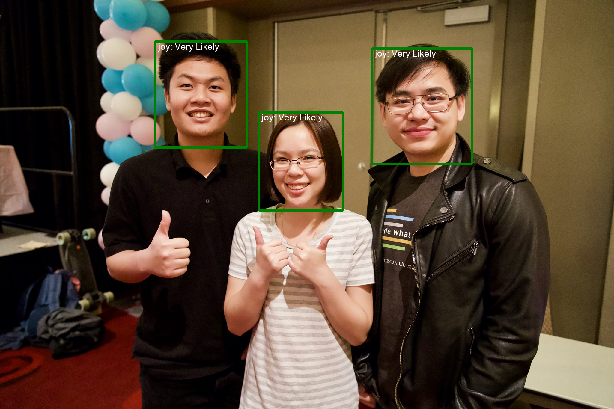

In [22]:
image_dis(content,response,30)

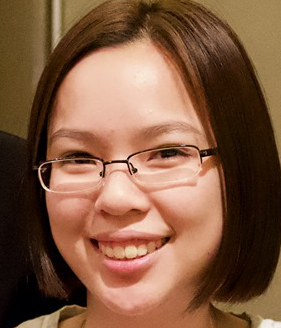

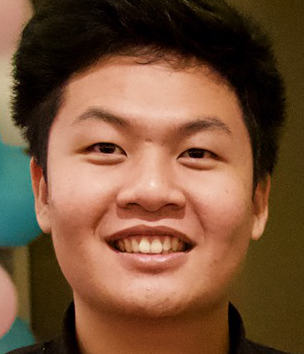

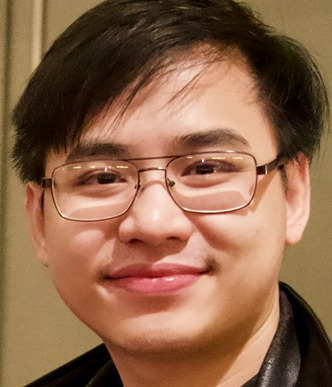

In [23]:
for i in crop_image(content,response):
    zoom=100
    width,height=int(i.width*zoom/100),int(i.height*zoom/100)
    display(i.resize((width,height)))